In [1]:
import os
from typing import List, Tuple

from langchain_community.utilities import SQLDatabase
from langchain.chains import create_sql_query_chain
from langchain_community.tools.sql_database.tool import QuerySQLDataBaseTool
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from operator import itemgetter
from sqlalchemy import create_engine
from langchain_community.agent_toolkits import create_sql_agent
import langchain

from langchain_groq.chat_models import ChatGroq
from langchain_ollama import ChatOllama

from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv(), override=True)

# langchain.debug = True

True

Database connection exists.


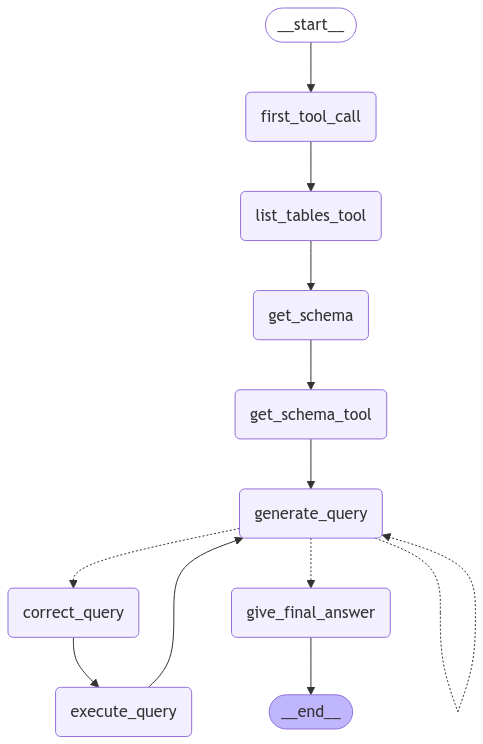

In [2]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

from src.agent import graph

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)



In [3]:
from langchain_core.messages import HumanMessage
# graph.invoke({"messages": [HumanMessage(content="how many entries are there?")]})
graph.invoke({"messages": [HumanMessage(content="give me all the customer emails with names including Nichols? and also give me dates for butter milk entries?")]})

In [6]:
from langchain_core.messages import AIMessageChunk, AIMessage
for msg, metadata in graph.stream(
                    input={"messages": [HumanMessage(content="give me the dates of first 10 entries of butter milk?")]},
                    stream_mode="messages",
                ):
    # print(msg)
    # tool_calls=[{'name': 'SubmitFinalAnswer', 'args': {'final_answer': 'There are 38765 groceries.'}
    if (
        msg.content
        and not isinstance(msg, HumanMessage)
        and metadata["langgraph_node"] == "give_final_answer"
    ):
        print(msg.content, end="|", flush=True)

In [ ]:
# Create SQLAlchemy engine
# engine = create_engine(os.getenv("SUPABASE_DATABASE_URL"))

# Initialize SQLDatabase with the engine
db = SQLDatabase.from_uri(os.getenv("SQL_SAMPLE_DB_URI"))
print(db.dialect)
print(db.get_usable_table_names())

context = db.get_context()
print(list(context))
print(context["table_info"])

In [ ]:
print(db.run("SELECT * FROM groceries LIMIT 5;"))

In [ ]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from src.llm import llm

toolkit = SQLDatabaseToolkit(db=db, llm=llm)
tools = toolkit.get_tools()
for tool in tools:
    print(f"{tool.name}: {tool.description}")

In [ ]:
toolkit = SQLDatabaseToolkit(db=db, llm=llm)
tools = toolkit.get_tools()

sql_db_list_tables = next(tool for tool in tools if tool.name == "sql_db_list_tables")
sql_db_schema = next(tool for tool in tools if tool.name == "sql_db_schema")
sql_db_query = next(tool for tool in tools if tool.name == "sql_db_query")
sql_db_query_checker = next(tool for tool in tools if tool.name == "sql_db_query_checker")

print("sql_db_list_tables: ", sql_db_list_tables.invoke(""))
print()
print("sql_db_schema: ", sql_db_schema.invoke("groceries"))

In [ ]:
result = sql_db_query.invoke("SELECT * FROM groceries LIMIT 5;")
print(result)

In [ ]:
sql_db_query_checker.invoke("SELECT * FROM groceries LIMIT 10;")

In [ ]:
sql_db_query_checker

In [ ]:
from langchain_community.tools.sql_database.prompt import QUERY_CHECKER

print(QUERY_CHECKER)

In [ ]:
from src.chains import query_checker_chain

query_checker_chain.invoke({"messages": [("user", "SELECT * FROM groceries LIMIT 10;")]})

In [ ]:
from src.nodes import first_tool_call, get_schema, generate_query
from src.tools import list_tables_tool, get_schema_tool
from langchain_core.messages import HumanMessage, ToolMessage

messages = []
messages.append(first_tool_call("")['messages'])
print(messages[-1])
print()
messages.append(ToolMessage(content=list_tables_tool.invoke(""), ))
print("tables: ", messages[-1])
print()
messages.append(get_schema({"messages": messages[-1]}))
print(messages[-1])
print()
messages.append(get_schema_tool.invoke({"table_names": messages[-1]['messages'][-1].tool_calls[-1]['args']['table_names']}))
print("Schema: ", messages[-1])
print()
messages.append(generate_query({"messages": messages}))
print(messages[-1])

In [ ]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

from src.agent import graph

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)



In [ ]:
from src.sql_utils import add_table_to_sqlite_db

add_table_to_sqlite_db(
                        file_path="E:\python projects\sql-agent-langgraph-streamlit\sample_excel\customer.csv",
                        sheet_name=os.getenv("SAMPLE_EXCEL_SHEET"),
                        db_path="E:\python projects\sql-agent-langgraph-streamlit\sql_db\sample_sqlite3.db",
                        table_name="customers",
                    )
add_table_to_sqlite_db(
                        file_path="E:\python projects\sql-agent-langgraph-streamlit\sample_excel\Groceries_dataset.csv",
                        sheet_name=os.getenv("SAMPLE_EXCEL_SHEET"),
                        db_path="E:\python projects\sql-agent-langgraph-streamlit\sql_db\sample_sqlite3.db",
                        table_name="groceries",
                    )

In [3]:
from langchain_community.agent_toolkits import create_sql_agent
from src.llm import llm

db = SQLDatabase.from_uri(
    "sqlite:///E:\python projects\sql-agent-langgraph-streamlit\sql_db\sample_sqlite3.db"
)
agent_executor = create_sql_agent(llm, db=db, agent_type="tool-calling", verbose=True)

response = agent_executor.invoke(
    {
        "input": "give me email of customers with Nichole in their names? and dates for entries of butter milk?",
    }
)
print(response)

In [ ]:
response['output']

In [ ]:
from langchain_core.messages import HumanMessage
# graph.invoke({"messages": [HumanMessage(content="how many entries are there?")]})
graph.invoke({"messages": [HumanMessage(content="give me customer emails with names including Nichols?")]})

In [ ]:
from langchain_core.messages import AIMessageChunk, AIMessage
for msg in graph.stream(
                    input={"messages": [HumanMessage(content="give me the dates of first 10 entries of butter milk?")]},
                    stream_mode="values",
                ):
    # print(msg)
    # tool_calls=[{'name': 'SubmitFinalAnswer', 'args': {'final_answer': 'There are 38765 groceries.'}
    if isinstance(msg['messages'][-1], AIMessage):
        if msg['messages'][-1].tool_calls:
            print('tool_call')
            if msg['messages'][-1].tool_calls[-1]['name'] == 'SubmitFinalAnswer':
                print(msg['messages'][-1].tool_calls[-1]['args']['final_answer'])
    # if isinstance(msg, AIMessage):
    #     print('aimsgchunk')
    #     if 'tool_calls' in msg['additional_kwargs']:
    #         if msg['additional_kwargs']['tool_calls'][-1]['name'] == 'SubmitFinalAnswer':
    #             print(msg['additional_kwargs']['tool_calls'][-1]['function']['arguments']['final_answer'])